In [ ]:
import json
import pandas
import time
import os
import recordlinkage
import jellyfish as jf
import csv

In [ ]:
outputDir = '..//scraped_json//'
field_agg = "_"

## Load the source file dict
sourceFiles = json.loads(open('..//config//sourceFiles.json', "r").read())

## Load the file schema
sourceSchema = json.loads(open('..//config//sourceSchema.json', "r").read())

## Load the id config
idConfig = json.loads(open('..//config//idConfig.json', "r").read())

In [ ]:
## If there are multiple files for any given dataset, then this function will combine all of those
## records into a single dict
def mergeSourceFiles (source, outputDir, sourceFiles):
    recordList = []
    for file in sourceFiles[source]:  
        file = json.loads(open(outputDir + file, "r", encoding="utf-8").read())
        for record in file:
            recordList.append(record)
    return recordList

In [ ]:
## Cycle through all of files per source and drop into a list of dicts
## Printing list names for reference sake
dfs = []
for key in sourceFiles.keys():
    vars()[key] = pandas.DataFrame(json.loads(open(summarizedDir + summarizedFiles[key][0], "r", encoding="utf-8").read()))
    dfs.append(vars()[key])

NameError: name 'summarizedDir' is not defined

In [ ]:
## Clean up dirty names
def mungeID(playerString):
    return ''.join(e for e in playerString if e.isalnum()).lower().replace("jr.", "").replace("st.", "state") 

In [ ]:
#create a universal identifier
#CHANGE - this is not going to be a list
#CFB-Ref reports it in chronological order so we will join based on position 1

def createNewID (fieldList, thisDict, fieldAgg):
    finalID= ''
    for i in thisDict:
        for idx, val in enumerate(fieldList):
            if (type(i[val]) is list):
                i[val]= mungeID(i[val][0])
                if (len(fieldList) -1 == idx):
                    finalID += str(i[val]).strip('[]').strip("''")
            elif (type(val) is not list):
                i[val] = mungeID(i[val])
                if (len(fieldList) - 1 == idx):
                    finalID += i[val]
                else:
                    finalID = i[val] + fieldAgg
        i['ID'] = finalID
        finalID=''

In [ ]:
createNewID(idConfig['sports247'], sports247, field_agg)
createNewID(idConfig['rivals'], rivals, field_agg)
createNewID(idConfig['cfbRef'], cfbRef, field_agg)
createNewID(idConfig['allConf'], allConf, field_agg)
createNewID(idConfig['allAmerican'], allAmerican, field_agg)
createNewID(idConfig['nflData'], nflData, field_agg)
createNewID(idConfig['ncaa'], ncaa, field_agg)

In [ ]:
df_sports247 = pandas.DataFrame(sports247)
df_rivals = pandas.DataFrame(rivals)
df_cfbRef = pandas.DataFrame(cfbRef)
df_allConf = pandas.DataFrame(allConf)
df_allAmerican = pandas.DataFrame(allAmerican)
df_nflData = pandas.DataFrame(nflData)
df_ncaa = pandas.DataFrame(ncaa)

In [ ]:
indexer = recordlinkage.Index()
indexer.block('school')
indexer.block('year')
candidate_links = indexer.index(df_sports247, df_rivals)

In [ ]:
c = recordlinkage.Compare()

c.exact('ID', 'ID', label='ID')

c.string('playerName', 'playerName', method='damerau_levenshtein', label='playerName')
c.string('school', 'school', label='college')
c.string('city', 'city', label='city')
c.exact('state', 'state', label='state')
c.string('highSchool', 'highSchool', label='highSchool')
c.exact('position', 'position', label='position')
c.exact('year', 'year', label='year')

# The comparison vectors
features = c.compute(candidate_links, df_sports247, df_rivals)

features

ID  playerName   college      city  state  highSchool  position  \
0     19      0    0.222222  0.000000  0.100000      0    0.208333         0   
      34      0    0.000000  1.000000  0.083333      0    0.083333         0   
      43      0    0.083333  1.000000  1.000000      1    1.000000         0   
      51      0    0.250000  1.000000  0.166667      0    0.090909         0   
      55      0    0.250000  1.000000  0.333333      0    0.105263         0   
...          ..         ...       ...       ...    ...         ...       ...   
17063 16853   0    0.058824  1.000000  0.222222      0    0.176471         0   
      16855   0    0.235294  1.000000  0.111111      0    0.200000         0   
      16856   0    0.117647  1.000000  0.333333      0    0.111111         0   
      16861   0    0.352941  0.125000  0.222222      0    0.111111         0   
      16877   0    0.117647  0.153846  0.111111      0    0.125000         0   

             year  
0     19        1  
      34        0  
      43        0  
      51        0  
      55        0  
...           ...  
17063 16853     0  
      16855     0  
      16856     0  
      16861     1  
      16877     1  

[22388448 rows x 8 columns]

In [ ]:
features['sum'] = (features['playerName'] + features['college'] + features['city'] + features['state'] + features['highSchool'] + features['year'] + features['position'])
features.describe()

,ID,playerName,college,city,state,highSchool,position,year,sum
count,2.238845e+07,2.238845e+07,2.238845e+07,2.238845e+07,2.238845e+07,2.238845e+07,2.238845e+07,2.238845e+07,2.238845e+07
mean,7.146989e-04,1.540184e-01,4.409827e-01,1.343968e-01,1.222338e-01,1.253481e-01,2.998832e-02,6.779464e-01,1.684915e+00
std,2.672430e-02,9.673058e-02,4.141739e-01,1.214204e-01,3.275556e-01,9.999665e-02,1.705550e-01,4.672634e-01,4.682073e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,8.333333e-02,1.111111e-01,7.142857e-02,0.000000e+00,6.666667e-02,0.000000e+00,0.000000e+00,1.391667e+00
50%,0.000000e+00,1.538462e-01,2.222222e-01,1.111111e-01,0.000000e+00,1.176471e-01,0.000000e+00,1.000000e+00,1.546620e+00
75%,0.000000e+00,2.142857e-01,1.000000e+00,1.875000e-01,0.000000e+00,1.764706e-01,0.000000e+00,1.000000e+00,1.785714e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00


<AxesSubplot:>

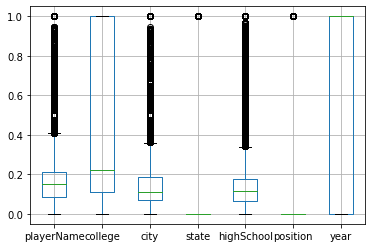

In [ ]:
features.boxplot(column=['playerName', 'college', 'city', 'state', 'highSchool', 'position', 'year'])

In [ ]:
not_id = features[features['ID'] != 1]
fuzzy_matches = (not_id[not_id['sum'] > 6.62].sort_values(by='sum')).to_dict()

In [ ]:
#df_sports247.head()
df_sports247.iloc[5618, :]

school                                   minnesota
year                                          2017
playerName                            jacobpaulson
highSchool         Christian Academy Of Louisville
city                                    Louisville
state                                           KY
position                                        TE
height                                          77
weight                                         245
compRating                                  0.8471
compStars                                        3
nationalRank                                   921
positionRank                                    42
stateRank                                        3
247Rating                                      NaN
247Stars                                       NaN
247positionRank                                NaN
247stateRank                                   NaN
ID                          jacobpaulson_minnesota
247nationalRank                

In [ ]:
test = df_rivals.iloc[2673, :]
test['year']

'2017'

In [ ]:
features.iloc[2673, :]

ID            0.000000
playerName    0.187500
college       1.000000
city          0.166667
state         0.000000
highSchool    0.000000
position      0.000000
year          0.000000
sum           1.354167
Name: (2, 837), dtype: float64

In [ ]:
print(fuzzy_matches)

{'ID': {(5618, 2673): 0, (5627, 2285): 0, (16265, 11918): 0, (8354, 6189): 0, (2749, 5638): 0, (16794, 15067): 0, (14638, 15928): 0, (12471, 14935): 0, (13764, 12531): 0, (15568, 14344): 0, (12689, 13543): 0, (11379, 14881): 0, (8808, 6789): 0, (4780, 2528): 0, (134, 594): 0, (138, 186): 0, (6512, 6751): 0, (12738, 13961): 0, (12355, 15055): 0, (6371, 8578): 0, (5244, 3921): 0, (1668, 2768): 0, (14547, 11375): 0, (3681, 2437): 0, (13142, 14452): 0, (411, 2164): 0, (4747, 4040): 0, (14274, 14354): 0, (7673, 8222): 0, (3498, 2903): 0, (6399, 8874): 0, (15233, 10404): 0, (5674, 4864): 0, (16001, 14446): 0, (6238, 6693): 0, (553, 1809): 0, (3690, 257): 0, (13439, 14751): 0, (9507, 6470): 0, (8625, 9121): 0, (12455, 16846): 0, (5719, 478): 0, (1353, 4373): 0, (14418, 12299): 0, (6042, 8722): 0, (15595, 14958): 0, (312, 669): 0, (14236, 15690): 0, (3688, 3871): 0, (5101, 628): 0, (9850, 6180): 0, (13300, 12988): 0, (13786, 16095): 0, (15986, 12300): 0, (16239, 10737): 0, (12361, 14374): 0, (

In [ ]:
ids_to_match = []
ids = fuzzy_matches['ID']
for key in ids.keys():
    i = {}
    print(key[0])
    i['247'] = key[0]
    i['rivals'] = key[1]
    ids_to_match.append(i)


5618
5627
16265
8354
2749
16794
14638
12471
13764
15568
12689
11379
8808
4780
134
138
6512
12738
12355
6371
5244
1668
14547
3681
13142
411
4747
14274
7673
3498
6399
15233
5674
16001
6238
553
3690
13439
9507
8625
12455
5719
1353
14418
6042
15595
312
14236
3688
5101
9850
13300
13786
15986
16239
12361
9360
6185
11378
16503
10802
5850
11404
16037
10296
10327
2422
12188
6613
718
14545
150
8542
9482
1198
4049
3143
15242
12163
14256
9684
3310
11765
4527
5476
1820
14285


In [ ]:
fuzzy_list = []
for i in ids_to_match:
    sports247_dict = pandas.DataFrame(df_sports247.iloc[i['247'], :]).to_dict()
    
    rivals_dict= pandas.DataFrame(df_rivals.iloc[i['rivals'], :]).to_dict()
    for i in rivals_dict:   
        sports247_dict.update(i)
    fuzzy_list.append(sport247_dict)

TypeError: 'int' object is not iterable

In [ ]:
print(fuzzy_list)

[{14285: {'school': 'missouri', 'year': '2007', 'playerName': 'derickwashington', 'highSchool': 'Raymore-Peculiar', 'city': 'Peculiar', 'state': 'MO', 'position': 'RB', 'height': 71.0, 'weight': '194', 'compRating': '0.8750', 'compStars': 3, 'nationalRank': '359', 'positionRank': '32', 'stateRank': '5', '247Rating': '  N/A  ', '247Stars': 0.0, '247positionRank': 'N/A', '247stateRank': 'N/A', 'ID': 'derickwashington_missouri', '247nationalRank': nan}, '_is_copy': <weakref at 0x7fb71c6a4950; to 'DataFrame' at 0x7fb82ae03ac0>, '_mgr': SingleBlockManager
Items: Index(['school', 'year', 'playerName', 'city', 'state', 'highSchool',
       'position', 'height', 'weight', 'stars', 'nationalRank', 'positionRank',
       'stateRank', 'ID'],
      dtype='object')
ObjectBlock: 14 dtype: object, '_item_cache': {}, '_attrs': {}, '_name': 13820, '_index': Index(['school', 'year', 'playerName', 'city', 'state', 'highSchool',
       'position', 'height', 'weight', 'stars', 'nationalRank', 'positionRank